In [4]:
from griddify import datasets

data = datasets.get_compound_descriptors()

       BalabanJ      BertzCT       Chi0      Chi0n      Chi0v       Chi1  \
0      1.991493   745.106132  17.267220  13.573497  15.206490  11.595754   
1      1.612423   974.844997  21.846724  18.770430  18.770430  14.969676   
2      1.419147  1141.768275  24.907202  21.343588  21.343588  17.601688   
3      2.003442  1009.225437  22.543241  17.200355  17.200355  14.866611   
4      1.531904   900.272986  21.139617  17.940889  18.757386  14.387961   
...         ...          ...        ...        ...        ...        ...   
10045  1.672363   875.269064  19.225404  14.762583  16.348580  13.046045   
10046  1.740300   945.129867  22.053831  17.985572  17.985572  15.046045   
10047  2.147276   662.642740  19.648054  16.358334  16.358334  13.159258   
10048  1.762308   813.260832  18.681434  14.685233  14.685233  12.473566   
10049  1.434526   799.303665  17.769374  14.154674  14.154674  12.813994   

           Chi1n      Chi1v     Chi2n     Chi2v  ...  fr_sulfonamd  \
0       7.778884 

In [8]:
import numpy as np

np.any(np.isnan(data))

False

In [39]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

class FeatureDistances(object):

    def __init__(self, metric="euclidean", max_n=10000):
        self.metric = metric
        self.max_n = max_n

    def calculate(self, data):
        D = squareform(pdist(np.array(data).T[:self.max_n,:], metric=self.metric))
        D[np.isnan(D)] = 0
        return D


fd = FeatureDistances().calculate(data)

In [43]:
from umap import UMAP

reducer = UMAP(metric="precomputed")
reducer.fit(fd)

/home/mduranfrigola/miniconda3/envs/tab2grid/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


UMAP(metric='precomputed', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

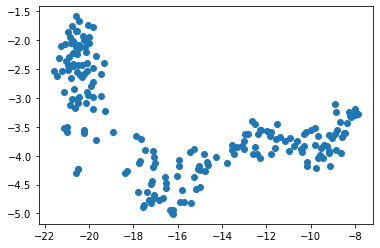

In [45]:
Xc = reducer.transform(fd)
plt.scatter(Xc[:,0], Xc[:,1])

In [100]:
import numpy as np
import lap
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans


GRIDDIFY_METRIC = "sqeuclidean"


class Cloud2Grid(object):

    def __init__(self, max_side=128):
        self._max_side=max_side
        self._clusters=None

    def _is_cloud(self, X):
        if len(X.shape) != 2:
            return False
        if X.shape[1] != 2:
            return False
        return True

    def _find_side(self, X):
        side = int(np.sqrt(X.shape[0]))
        if side > self._max_side:
            side = self._max_side
        return side

    def _needs_downsampling(self, X):
        avail = self._side**2
        assert avail <= X.shape[0]
        if avail == X.shape[0]:
            return False
        else:
            return True

    def _downsample_with_clustering(self, X):
        self._clusters = KMeans(n_clusters=self._side**2)
        self._clusters.fit(X)
        centroids = self._clusters.cluster_centers_
        return centroids

    def _griddify(self, X):
        xv, yv = np.meshgrid(np.linspace(0, 1, self._side), np.linspace(0, 1, self._side))
        self.grid = np.dstack((xv, yv)).reshape(-1, 2)
        cost = cdist(self.grid, X, GRIDDIFY_METRIC)
        cost = cost * (1000000 / cost.max())
        cost = cost.astype(int)
        min_cost, row_assigns, col_assigns = lap.lapjv(cost)
        self._grid_jv = self.grid[col_assigns]
        self._min_cost = min_cost
        self._row_assigns = row_assigns
        self._col_assigns = col_assigns

    def _grid_coordinates_as_integers(self, X):
        X = X*self._side
        X = X.astype(int)
        return X

    def fit(self, X):
        assert self._is_cloud(X)
        self._side = self._find_side(X)
        self._do_cluster = self._needs_downsampling(X)
        if self._do_cluster:
            X = self._downsample_with_clustering(X)
        self._griddify(X)
        self.nearest_neighbors = NearestNeighbors(n_neighbors=1)
        self.nearest_neighbors.fit(X)

    def transform(self, X, as_integers=False):
        assert self._is_cloud(X)
        idxs = self.nearest_neighbors.kneighbors(X, return_distance=False)
        X_grid = np.zeros((X.shape[0], 2))
        for i, idx in enumerate(idxs[:,0]):
            X_grid[i] = self._grid_jv[idx]
        if as_integers:
            return self._grid_coordinates_as_integers(X_grid)
        else:
            return X_grid


cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
Xg = cg.transform(Xc, as_integers=False)

In [101]:
from scipy.spatial.distance import euclidean

def arrows_plot(X_cloud, X_grid, ax):
    dists = []
    for start, end in zip(X_cloud, X_grid):
        dists += [euclidean(start, end)]
    for start, end in zip(X_cloud, X_grid):
        ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], head_length=0.01, head_width=0.01)
    return ax

<AxesSubplot:>

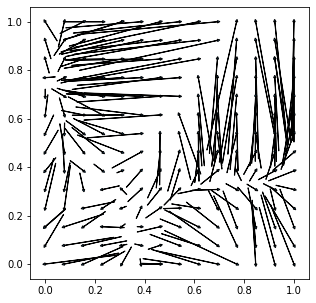

In [102]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

arrows_plot(Xc, Xg, ax=ax)

In [106]:
Xg = cg.transform(Xc, as_integers=True)

import numpy as np


class Tabular2Grid(object):

    def __init__(self, cloud2grid):
        self._size = cloud2grid._size
        self._empty_grid = cloud2grid.get_empty_grid()
        
    def fit(self, X_grid):
        assert X_grid.astype(int) == X_grid
        self._mapper = X_grid
        
    def transform(self, X):
        Xt = []
        for i in X.shape[0]:
            g = self._empty_grid.copy()
            x = X[i,:]
            for j, v in enumerate(x):
                idx_i, idx_j = self._mapper[j]
                g[idx_i, idx_j] = v
            Xt += [g]
        return np.array(Xt)

tg = Tabular2Grid(cg)
tg.fit(Xg)

AttributeError: 'Cloud2Grid' object has no attribute '_size'

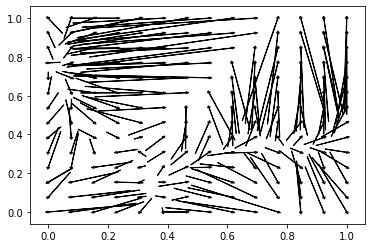

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(Xc)
Xc = scaler.transform(Xc)

for start, end in zip(Xc, Xg):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

array([[0.69230769, 0.        ],
       [1.        , 0.84615385],
       [1.        , 0.15384615],
       [0.92307692, 0.23076923],
       [0.92307692, 0.30769231],
       [0.84615385, 0.07692308],
       [0.76923077, 0.53846154],
       [0.76923077, 0.23076923],
       [0.76923077, 0.07692308],
       [0.76923077, 0.30769231],
       [0.69230769, 0.23076923],
       [0.69230769, 0.53846154],
       [0.69230769, 0.61538462],
       [0.69230769, 0.69230769],
       [0.84615385, 0.84615385],
       [0.84615385, 0.69230769],
       [0.30769231, 0.76923077],
       [0.84615385, 0.61538462],
       [0.92307692, 0.07692308],
       [0.92307692, 0.61538462],
       [0.84615385, 0.        ],
       [0.92307692, 0.        ],
       [1.        , 0.23076923],
       [1.        , 0.        ],
       [0.76923077, 1.        ],
       [1.        , 0.76923077],
       [0.53846154, 0.30769231],
       [0.53846154, 0.38461538],
       [0.61538462, 0.23076923],
       [0.38461538, 0.30769231],
       [0.